In [1]:
import random
import joblib as jl
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import extract
import make_feature
import get_whois
from file_io import load_urls

In [2]:
def show_result(y_true, y_pred, thresh):
    pred = []
    for i in y_pred:
        if i > thresh:
            pred.append(1)
        else:
            pred.append(0)
    print "\n\n", classification_report(y_true, pred, digits = 4)
    print confusion_matrix(y_true, pred)

def xgb_prediction(data, urls, bst, thresh = 0.5, ntree_limit = 0):
    data = xgb.DMatrix(data, [0 for _ in range(len(data))])
    prediction = []
    y_pred = bst.predict(data, ntree_limit = ntree_limit)
    for pred, url in zip(y_pred, urls):
        if pred > thresh:
            prediction.append(url)
    print "prediction:%d\trecall:%.3f" %(len(prediction), len(prediction)/float(len(urls)))
    return prediction

def xgb_prediction_detail(mal_data, ben_data, bst, thresh = 0.5, ntree_limit = -1):
    data = np.concatenate((mal_data, ben_data), axis = 0)
    y_true = [1 for _ in range(len(mal_data))] + [0 for _ in range(len(ben_data))]
    data = xgb.DMatrix(data, y_true)
    y_pred = bst.predict(data)
    show_result(y_true, y_pred, thresh)
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    p, r, thresh = precision_recall_curve(y_true, y_pred)
    return fpr, tpr, p, r

In [5]:
url_ip_map = jl.load("../data/exp_rule/ip/url_ip_map2.jl.z" )
url_ip_dmap = jl.load('../data/exp_rule/ip/url_ip_dmap2.jl.z')
domain_rank_map = jl.load('../data/exp_rule/alexa_rank/alexa_rank2.jl.z')
domain_cert_map = jl.load('../data/exp_rule/cert/certificate2.jl.z')

domain_whois_map = get_whois.load_whois_dict(path = "../data/exp_rule/whois")
domain_pr_map = jl.load("../data/exp_rule/pr/pr.jl.z")
sus_domain = jl.load("../data/exp_rule/sus_domain/sus_domain.jl.z")

In [6]:
df_mal = pd.read_csv("../std_data/0615/df_mal_cv3_hard.csv")
df_ben = pd.read_csv("../std_data/0615/df_ben_cv3_hard.csv")
unk_urls = load_urls("../std_data/0615/unk.csv")

pred_ben_all = list()
pred_unk_all = list()
fpr_all, tpr_all, p_all, r_all = list(), list(), list(), list()

cv = 3

for i in range(cv):
    print "========= %d ==========" %i
    test_mal_urls = list(df_mal.loc[df_mal.cv == i].urls)
    test_ben_urls = list(df_ben.loc[df_ben.cv == i].urls)
    train_mal_urls = list(set(df_mal.urls) - set(test_mal_urls))
    train_ben_urls = list(set(df_ben.urls) - set(test_ben_urls))
    print len(train_mal_urls), len(train_ben_urls)
    print len(test_mal_urls), len(test_ben_urls)
    
    data_obj = extract.FeatureExtract(train_mal_urls, train_ben_urls)
    data_obj.feature_extract(url_ip_dmap)
    
    feat_obj = make_feature.build_feature(data_obj, url_ip_map, url_ip_dmap, domain_whois_map, domain_rank_map, domain_cert_map, \
                                      domain_pr_map, sus_domain)
    
    train_mal_x = feat_obj.build_feature_set(train_mal_urls)
    train_ben_x = feat_obj.build_feature_set(train_ben_urls)
    test_mal_x = feat_obj.build_feature_set(test_mal_urls)
    test_ben_x = feat_obj.build_feature_set(test_ben_urls)
    unk_x = feat_obj.build_feature_set(unk_urls)
    
    train_x = np.concatenate((train_mal_x,train_ben_x), axis = 0)
    train_y = [1] * len(train_mal_x) + [0] * len(train_ben_x)

    test_x =  np.concatenate((test_mal_x, test_ben_x), axis = 0)
    test_y = [1] * len(test_mal_x) + [0] * len(test_ben_x)
    
    dtrain = xgb.DMatrix(train_x, train_y)
    dtest  = xgb.DMatrix(test_x, test_y)

    params={
    'booster': 'gbtree',
    'objective':'binary:logistic',
    'gamma':0.1,  
    'max_depth':12, 
    'lambda':2,  
    'subsample':1, 
    'colsample_bytree':1, 
    'min_child_weight':1, 
    'silent':0 ,
    'eta': 0.2, 
    'seed':1000,
    'nthread':8
    }

    watchlist  = [(dtest,'eval'), (dtrain,'train')]  
    num_round = 200
    bst = xgb.train(params, dtrain, num_round, watchlist)   
    
    
    ntree_limit = -1
    thresh = 0.8

    pred_ben_train = xgb_prediction(train_ben_x, train_ben_urls, bst, thresh = thresh, ntree_limit = ntree_limit )
    pred_mal_train = xgb_prediction(train_mal_x, train_mal_urls, bst, thresh = thresh, ntree_limit = ntree_limit )
    print ""
    pred_ben = xgb_prediction(test_ben_x, test_ben_urls, bst, thresh = thresh, ntree_limit = ntree_limit )
    pred_mal = xgb_prediction(test_mal_x, test_mal_urls, bst, thresh = thresh, ntree_limit = ntree_limit )
    print ""
    pred_unk = xgb_prediction(unk_x, unk_urls, bst, thresh = thresh, ntree_limit = ntree_limit )
    fpr, tpr, p, r = xgb_prediction_detail(test_mal_x, test_ben_x, bst, thresh = thresh, ntree_limit = -1)
    
    # recode some data
    pred_ben_all.extend(pred_ben)
    pred_unk_all.extend(pred_unk)
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    p_all.append(p)
    r_all.append(r)

2018-06-20 17:04:07 file_io.py [line:52] DEBUG	URLs Count:	1429


========= 0 ==========
9541 38898
4609 22776
[0]	eval-error:0.027095	train-error:0.001734
[1]	eval-error:0.027095	train-error:0.001734
[2]	eval-error:0.027095	train-error:0.001734
[3]	eval-error:0.027095	train-error:0.001734
[4]	eval-error:0.027095	train-error:0.001734
[5]	eval-error:0.027095	train-error:0.001734
[6]	eval-error:0.027095	train-error:0.00159
[7]	eval-error:0.027095	train-error:0.00159
[8]	eval-error:0.027095	train-error:0.001548
[9]	eval-error:0.027095	train-error:0.001548
[10]	eval-error:0.027095	train-error:0.001466
[11]	eval-error:0.027095	train-error:0.001424
[12]	eval-error:0.027059	train-error:0.001363
[13]	eval-error:0.027059	train-error:0.001321
[14]	eval-error:0.027059	train-error:0.001321
[15]	eval-error:0.027059	train-error:0.001239
[16]	eval-error:0.027059	train-error:0.001218
[17]	eval-error:0.027387	train-error:0.001177
[18]	eval-error:0.027424	train-error:0.001177
[19]	eval-error:0.027241	train-error:0.001177
[20]	eval-error:0.027278	train-error:0.001177
[

[176]	eval-error:0.032463	train-error:0.000475
[177]	eval-error:0.032463	train-error:0.000475
[178]	eval-error:0.032463	train-error:0.000475
[179]	eval-error:0.032463	train-error:0.000475
[180]	eval-error:0.032463	train-error:0.000475
[181]	eval-error:0.032463	train-error:0.000475
[182]	eval-error:0.032463	train-error:0.000475
[183]	eval-error:0.032463	train-error:0.000475
[184]	eval-error:0.032463	train-error:0.000475
[185]	eval-error:0.032463	train-error:0.000475
[186]	eval-error:0.032463	train-error:0.000475
[187]	eval-error:0.032463	train-error:0.000475
[188]	eval-error:0.032463	train-error:0.000475
[189]	eval-error:0.032463	train-error:0.000475
[190]	eval-error:0.032463	train-error:0.000475
[191]	eval-error:0.032463	train-error:0.000475
[192]	eval-error:0.032463	train-error:0.000475
[193]	eval-error:0.032463	train-error:0.000475
[194]	eval-error:0.032463	train-error:0.000475
[195]	eval-error:0.032463	train-error:0.000475
[196]	eval-error:0.032463	train-error:0.000475
[197]	eval-er

[144]	eval-error:0.030454	train-error:0.000545
[145]	eval-error:0.030454	train-error:0.000545
[146]	eval-error:0.030454	train-error:0.000545
[147]	eval-error:0.030454	train-error:0.000545
[148]	eval-error:0.030454	train-error:0.000545
[149]	eval-error:0.030454	train-error:0.000545
[150]	eval-error:0.030454	train-error:0.000545
[151]	eval-error:0.030454	train-error:0.000545
[152]	eval-error:0.030454	train-error:0.000545
[153]	eval-error:0.030454	train-error:0.000545
[154]	eval-error:0.030454	train-error:0.000545
[155]	eval-error:0.030454	train-error:0.000545
[156]	eval-error:0.030454	train-error:0.000545
[157]	eval-error:0.030454	train-error:0.000545
[158]	eval-error:0.030454	train-error:0.000545
[159]	eval-error:0.030454	train-error:0.000545
[160]	eval-error:0.030454	train-error:0.000545
[161]	eval-error:0.030454	train-error:0.000545
[162]	eval-error:0.030454	train-error:0.000545
[163]	eval-error:0.030454	train-error:0.000545
[164]	eval-error:0.030454	train-error:0.000545
[165]	eval-er

[112]	eval-error:0.027375	train-error:0.000224
[113]	eval-error:0.027782	train-error:0.000224
[114]	eval-error:0.027375	train-error:0.000224
[115]	eval-error:0.027375	train-error:0.000224
[116]	eval-error:0.027375	train-error:0.000224
[117]	eval-error:0.027375	train-error:0.000224
[118]	eval-error:0.027375	train-error:0.000224
[119]	eval-error:0.027375	train-error:0.000224
[120]	eval-error:0.027375	train-error:0.000224
[121]	eval-error:0.027375	train-error:0.000224
[122]	eval-error:0.027375	train-error:0.000224
[123]	eval-error:0.027375	train-error:0.000224
[124]	eval-error:0.027375	train-error:0.000224
[125]	eval-error:0.027375	train-error:0.000224
[126]	eval-error:0.027375	train-error:0.000224
[127]	eval-error:0.027375	train-error:0.000224
[128]	eval-error:0.027375	train-error:0.000224
[129]	eval-error:0.027375	train-error:0.000224
[130]	eval-error:0.027375	train-error:0.000224
[131]	eval-error:0.027375	train-error:0.000224
[132]	eval-error:0.027375	train-error:0.000224
[133]	eval-er

2018-06-20 17:05:59 __init__.py [line:90] DEBUG	backend module://ipykernel.pylab.backend_inline version unknown


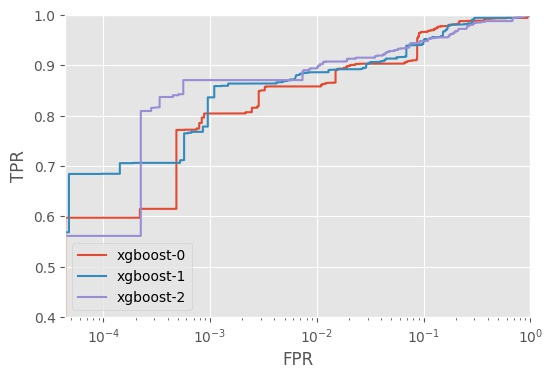

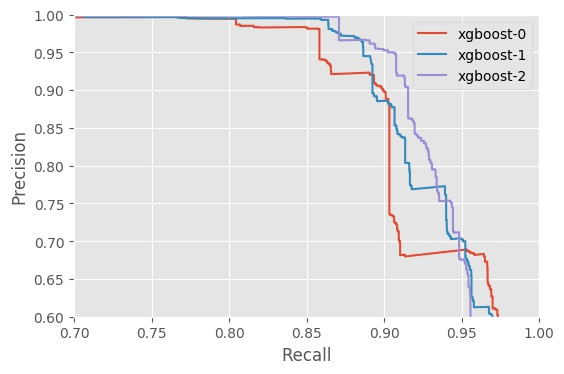

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('jpg')

plt.style.use('ggplot')

fig = plt.figure(figsize = (6,4), dpi = 100)
plt.xscale('log')
for i in range(cv):
    plt.plot(fpr_all[i], tpr_all[i])
plt.ylim(0.4,1)
plt.xlim(-1,1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(["xgboost-%d"% _ for _ in range(cv)])


fig = plt.figure(figsize = (6,4), dpi = 100)
for i in range(cv):
    plt.plot(r_all[i], p_all[i])
plt.xlim(0.7,1)
plt.ylim(0.6,1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(["xgboost-%d"% _ for _ in range(cv)])